In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd

# Matplotlib setup
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.switch_backend('Agg')

# Enable inline plotting (Kaggle compatibility)
%matplotlib inline

import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Set a nice seaborn style
sns.set(style='whitegrid')

## Data Import and Preprocessing

In [2]:
# Load the dataset
file_path = '/kaggle/input/fake-news-detection-dataset/fake_news_dataset.csv'
df = pd.read_csv(file_path, encoding='ascii')

# Display the first few rows to verify loading
df.head()

# Convert the 'date' column to datetime (the format is implied as string in the dataset description)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for missing values
missing_values = df.isnull().sum()
print('Missing values by column:')
print(missing_values)

# For simplicity, drop rows with missing labels or text
df = df.dropna(subset=['label', 'text'])

# Create additional numeric features for exploratory analysis
df['title_length'] = df['title'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df['text_length'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Display updated dataframe info
df.info()

Missing values by column:
title          0
text           0
date           0
source      1000
author      1000
category       0
label          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         20000 non-null  object        
 1   text          20000 non-null  object        
 2   date          20000 non-null  datetime64[ns]
 3   source        19000 non-null  object        
 4   author        19000 non-null  object        
 5   category      20000 non-null  object        
 6   label         20000 non-null  object        
 7   title_length  20000 non-null  int64         
 8   text_length   20000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 1.4+ MB


## Exploratory Data Analysis

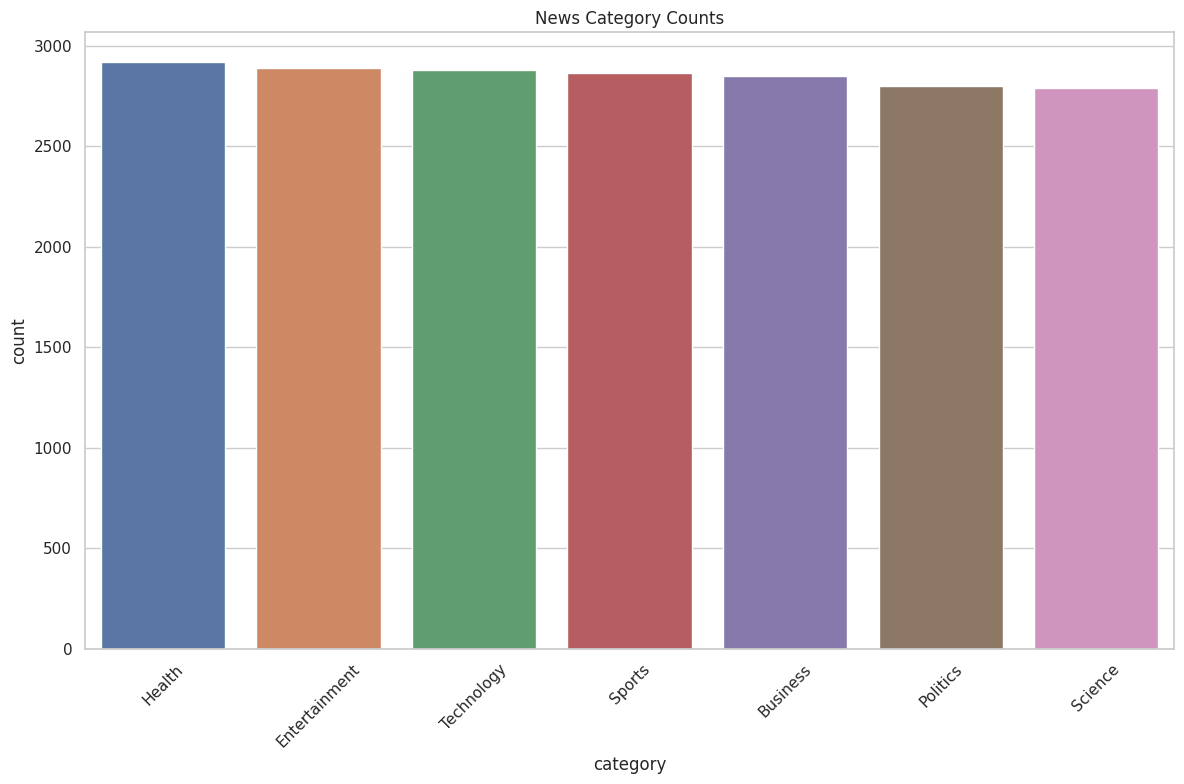

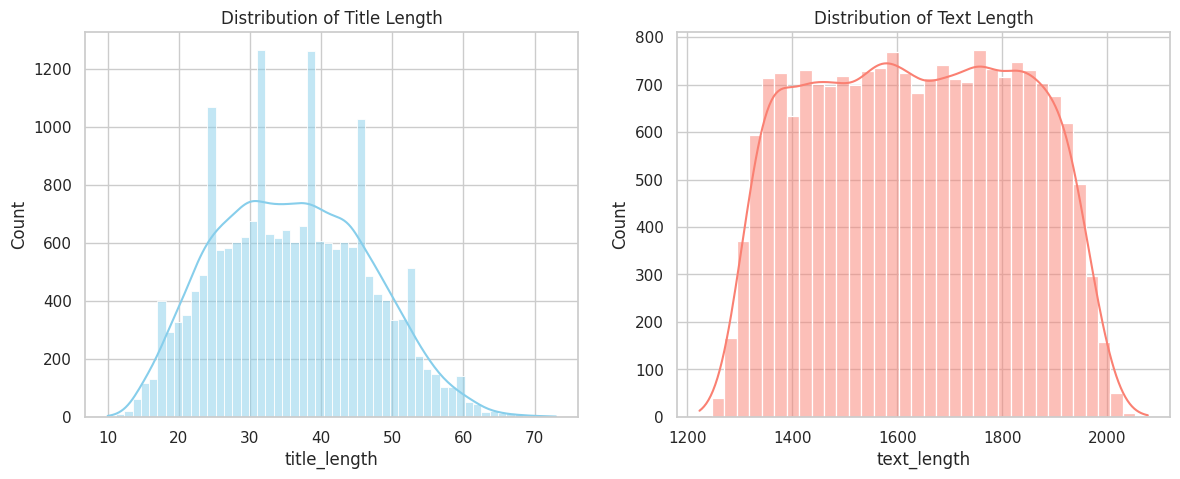

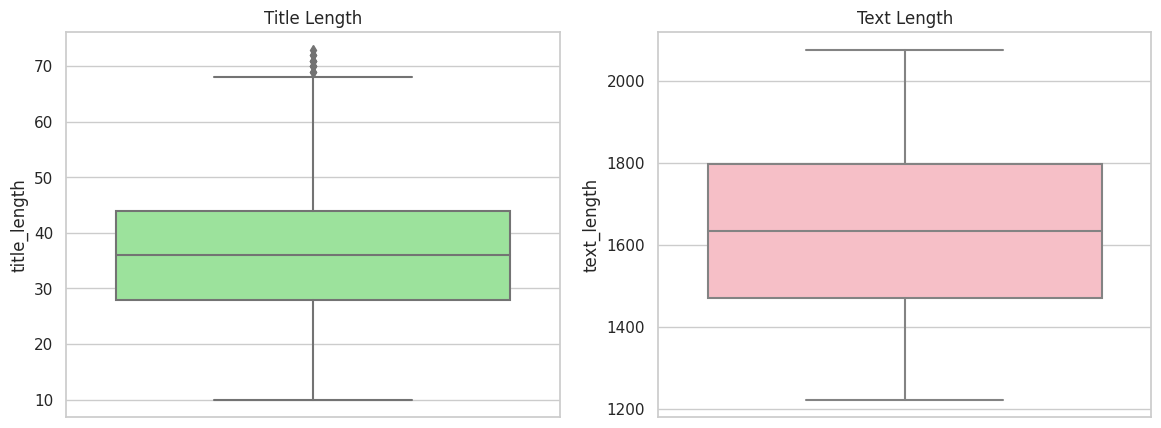

Not enough numeric columns for a meaningful correlation heatmap.


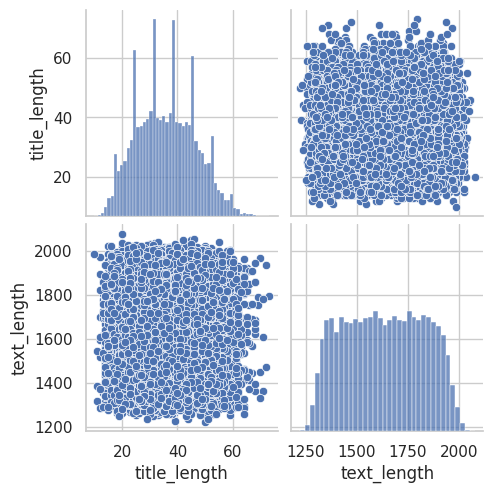

In [3]:
# Set the figure size for our plots
plt.figure(figsize=(12, 8))

### Category Distribution
# Using a countplot (pie charts can be limited for many categories)
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.title('News Category Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Numerical Features Analysis
# Histograms for title and text length
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['title_length'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Title Length')

sns.histplot(df['text_length'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Text Length')
plt.show()

### Box Plots for Numerical Features
# A box plot can offer insights into potential outliers in the data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(y=df['title_length'], ax=axes[0], color='lightgreen')
axes[0].set_title('Title Length')

sns.boxplot(y=df['text_length'], ax=axes[1], color='lightpink')
axes[1].set_title('Text Length')
plt.show()

### Correlation Analysis
# We select only numeric columns for correlation analysis. In this case we have 'title_length' and 'text_length'.
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap.')

### Pair Plot
# Even though only two numeric features exist, a pair plot can help visualize their relationships
sns.pairplot(numeric_df)
plt.show()

## Prediction Model

Prediction Accuracy: 0.5098


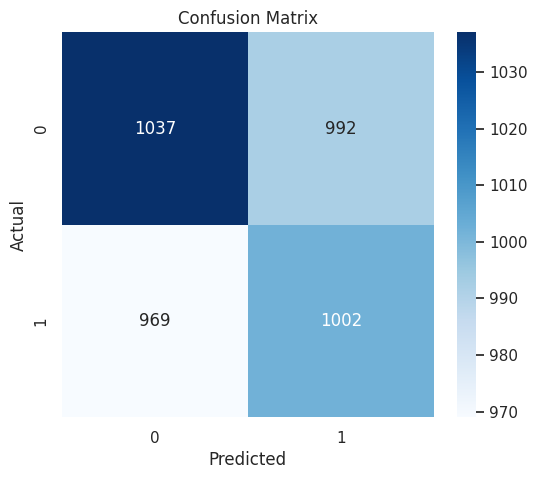

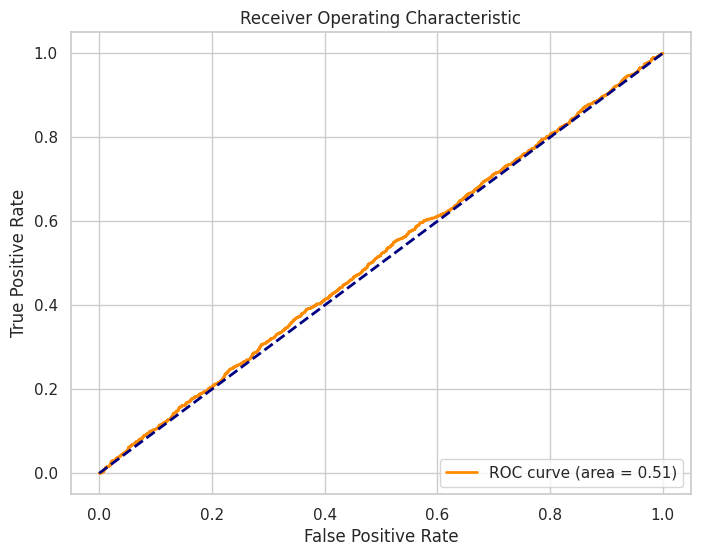

In [4]:
# For our prediction model, we use TF-IDF to convert the 'text' column into numeric features.
# Then we use Logistic Regression to predict the 'label'. This is a minimal predictor to demonstrate the approach.

from sklearn.preprocessing import LabelEncoder

# Encode the target variable: assuming labels are strings like 'fake' and 'true'
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'].str.lower())

# Prepare the text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = vectorizer.fit_transform(df['text'])

# Define features and target
X = X_text  
y = df['label_encoded']

# Split the dataset into training and testing sets in a reproducible manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and display the prediction accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy:.4f}')

### Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC Curve
# Since we have a binary classification, compute the ROC curve
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Conclusion

In this notebook we started with a curiosity for uncovering insights from a fake news dataset. We performed data preprocessing and featured engineering by converting dates and creating text-based numeric features. The exploratory analysis revealed distributions in text and title lengths as well as category imbalances. 

Our minimal prediction model used a TF-IDF representation of the news text and logistic regression to distinguish between fake and true news. While the performance is modest and there is headroom for improvement, this analysis demonstrates a baseline approach and potential avenues, such as incorporating additional textual features or exploring deep learning methods, for future work.

If you found these methods, visualizations, and insights useful, please consider upvoting the notebook.